# Link prediction challenge

We are using graph-tool (only available in Mac/Linux) and pytorch/dgl (sometimes hard to install). To make sure everything works let's run it on google colab
[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jgarciab/NetworkScience/blob/main/Practicals/day3/day3b_link_prediction.ipynb) 

In [1]:
# # Run only on Google Colab
# !pip install -q condacolab
# import condacolab
# condacolab.install() # expect a kernel restart

In [2]:
## If you are running this on your computer you can install the libraries uncommenting these lines
## Don't mix installations with conda and installations with pip (bad practice)
#!mamba install -c conda-forge graph-tool scikit-learn pytorch_geometric --yes
#!mamba install -c pytorch pytorch  --yes
#!pip install node2vec scipy==1.12



In [3]:
# networks
import networkx as nx
import graph_tool.all as gt
from graph_tool import topology, inference, generation, stats, correlations, clustering

# machine learning
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

# embeddings
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA, TruncatedSVD, NMF

# Some math
import scipy.sparse as sp
import numpy as np
from numpy.linalg import inv

# data wrangling
import pandas as pd
import itertools

# viz
import pylab as plt

# Neura networks
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data         # <-- PyG basic graph container
from torch_geometric.nn import SAGEConv       # <-- GraphSAGE layer in PyG
from torch_geometric.utils import negative_sampling



# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [4]:
# If you run it on your own computer
path_data = "../../Data/"

# Don't change this on colab
#path_data = "./"

# Set-up of the challenge
We are going to use a protein-protein interaction network from S. cervisiae (the yeast that is used to make beer, bread and all sort of yummy things): http://interactome.dfci.harvard.edu/S_cerevisiae/download/YuSci2008.pdf

For the in-class examples, we will use the Twitter network. For the challenge change the `network = "twitter"` to `network = "ppi"` in the cell below.
```

In [5]:
network = "twitter"

# Read network (download it from internet) 
## ONLY IN COLAB! (otherwise use the data from the Data folder, no need to download)
#!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction.graphml 
#!wget https://github.com/jgarciab/NetworkScience/raw/main/Data/{network}_network_prediction_test.csv

# Path network
path_network = f"{path_data}/{network}_network_prediction.graphml"

# Read to networkx, this allows us to use the networkx functions
if network == "ppi":
    G = nx.read_graphml(path_network, node_type=int)
else:
    G = nx.read_graphml(path_network)
    
# Read to graph-tool, this allows us to use the graph-tool functions
g = gt.load_graph(path_network)
num_vertices = g.num_vertices()

# The node names in graph-tool are different from the ones in networkx
# let's create a dictionary to map graph-tool node labels to networkx node labels
if network == "ppi":
    gt_to_networkx_labels = dict((i, int(g.vp['_graphml_vertex_id'][i])) for i in range(g.num_vertices()))
else:
    gt_to_networkx_labels = dict((i, g.vp['_graphml_vertex_id'][i]) for i in range(g.num_vertices()))



### How does our network looks like

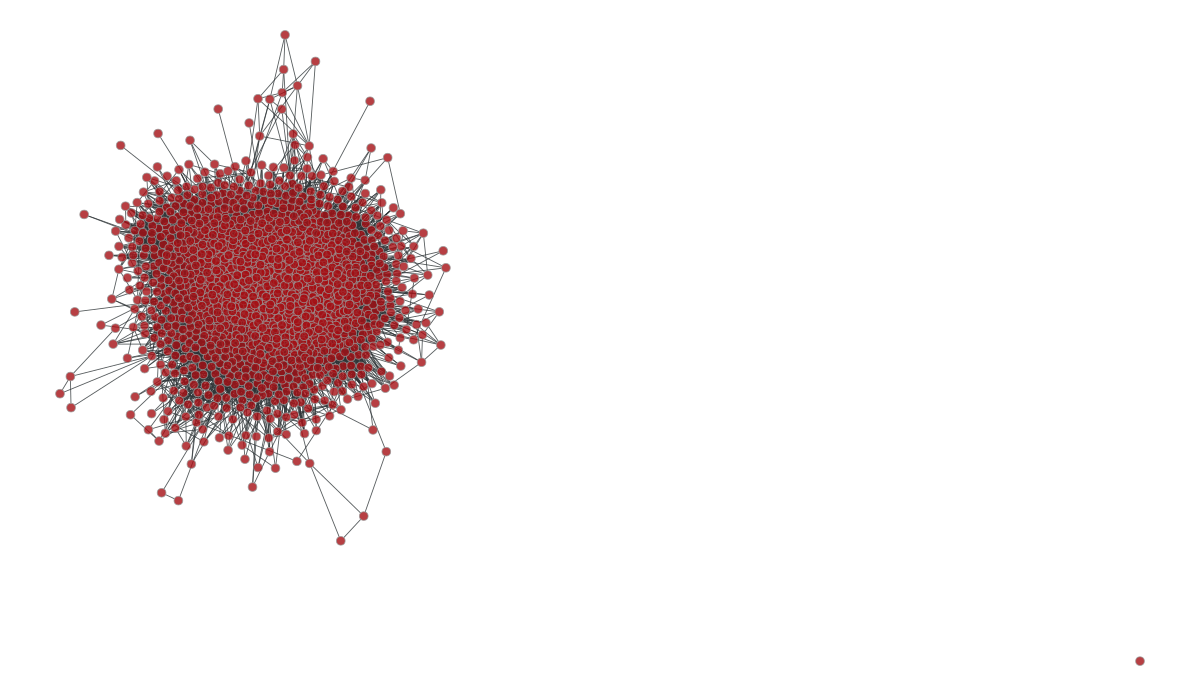

Global clustering:  0.17180199363203535 (0.17180199363203535, 0.003883580131516155)
Degree assortativity:  -0.033464131292299366 (-0.03346413129230163, 0.007987235533179066)


<Figure size 1000x1000 with 0 Axes>

In [6]:
# Plotting the network using graph-tool
plt.figure(figsize=(10,10))
gt.graph_draw(g)
# Calculating the clustering and assotativity using networkx and graph-tool
print("Global clustering: ", nx.transitivity(G), clustering.global_clustering(g, sampled=False))
print("Degree assortativity: ", nx.assortativity.degree_assortativity_coefficient(G), correlations.scalar_assortativity(g, "total"))

### Define all possible edges (all N^2 combination of nodes)

We are trying to predict which one of those edges exist, and which don't. We are going to use the network structure to predict this.

- df_edgelist: list of possible edges with labels: We will use this dataset to train the model.
- df_test: list of potential edges (50% that acutally exist, 50% that do not exist). We will use this dataset to test the predictions.

- Columns of both datasets:
    - 0: source node
    - 1: target node
    - "edge": label (1 if edge exists, 0 if edge does not exist)

In [7]:
# create dataframe all possible edges in theory (N*(N-1))
all_edges_gt = list(itertools.product(range(g.num_vertices()), repeat=2))
all_edges_nx = list(itertools.product(G.nodes(), repeat=2))
df_edgelist = pd.DataFrame([vi for vi in all_edges_gt])
display(df_edgelist.head())

# Convert the nodes names to have the same names as we had in networkx
df_edgelist[0] = df_edgelist[0].map(gt_to_networkx_labels)
df_edgelist[1] = df_edgelist[1].map(gt_to_networkx_labels)
df_edgelist.head()

# Merge with dataframe with actual links to create dummy variable (link / no link)
df_pos = pd.DataFrame(G.edges())
df_pos["edge"] = 1
df_edgelist = pd.merge(df_edgelist, df_pos, how="left")
df_edgelist["edge"] = df_edgelist["edge"].fillna(0) #the ones that were not present in df_pos represent absence of links
display(df_edgelist.head())

df_edgelist_no_self_loops = df_edgelist[df_edgelist[0] != df_edgelist[1]]

# Read test dataset (we will be testing our predictions on this one. Do not use this data for anything else)
df_test = pd.read_csv(f"{path_data}/{network}_network_prediction_test.csv", sep="\t", index_col=0)
df_test.columns = [0,1,"label"]
if network == "twitter":
    df_test[0] = df_test[0].astype(str)
    df_test[1] = df_test[1].astype(str)
# Drop duplicates (oops)
df_test = df_test.drop_duplicates(subset=[0,1])
df_test.head()

,0,1
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


,0,1,edge
0,0,0,0.0
1,0,1,1.0
2,0,217,1.0
3,0,476,1.0
4,0,1324,1.0


,0,1,label
0,448,37,1
1,165,881,1
2,118,102,1
3,574,236,1
4,364,937,1


### Define the function to test our predictions

In [8]:
def create_predictions(df_edgelist, df_test, columns = None, return_test = False, solver="lbfgs"):
    """
    Train a LogisticRegression given the labels from df_all_pairs and the scores from df_s. 
    The model is evaluated in the test dataset

    Input:
    - df_edgelist: Columns 0,1,edge (edge = presence of a link in the training data (the graph)), variables to use as predictors
    - df_ test: Columns 0,1, link (link = presence of a link in the test data (the actual graph))
    - return_test: if True, return the test dataset with the predictions
    - columns: list of columns to use as predictors
    - solver: solver to use in the LogisticRegression 

    Output:
    - If return_test is True, return the test dataset with the predictions
    - If return_test if False, return the predicted probabilities of all potential links
    """
    if columns is None:
        # Use all columns except the first two as independent variables (the first two are the labels)
        columns = list(df_edgelist.columns)[3:]

    # Create model and fit using cross-validation
    model = LogisticRegressionCV(cv=5, max_iter=1000,
                                  class_weight="balanced", n_jobs=-1, scoring="f1",
                                  solver=solver)
    
    # Remove self-loops (not necessarily what you want to do always, espcially in biological networks)
    df_edgelist = df_edgelist.loc[df_edgelist[0] != df_edgelist[1]]

    # Scale features
    X = df_edgelist[columns]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model.fit(X, df_edgelist["edge"])
    print(f"Intercept: {model.intercept_[0]: 2.2f}")
    for var, col in zip(columns, model.coef_[0]):
        print(f"{var}: {col: 2.2f}")

    # Predict labels for all pairs
    df_edgelist["pred"] = model.predict(X)

    # Merge the predictions with the test dataset to evaluate the prediction
    df_test = pd.merge(df_test, df_edgelist, on=[0,1], how="inner", validate="1:1")

    print(classification_report(df_test["label"], df_test["pred"]))

    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, scaler.transform(df_test[columns]), df_test["label"]) 
    plt.plot([0,1], [0,1], "--", color="lightgray", zorder=0)
    plt.grid(True)

    if return_test:
        df_test["pred_prob"] = model.predict_proba(scaler.transform(df_test[columns]))[:,1]
        return df_test
    
    # return predicted probabilities
    return model.predict_proba(X)[:,1]



## 2. Methods based on similarity

The following methods calculate node similarity looking mostly at (variations of) common neighbors.

In graph-tool, this is done with the function s_jaccard = gt.vertex_similarity(g, "jaccard"): https://graph-tool.skewed.de/static/doc/topology.html#graph_tool.topology.vertex_similarity



In [9]:
# Calculate jaccard similarity, convert to dataframe (cols 0 and 1 are the node ids)
## calculate jaccard similarity and convert to an array
s_jaccard = gt.vertex_similarity(g, "jaccard")

df_edgelist2 = df_edgelist.copy()

# add a column with the jaccard similarity between node pairs
df_edgelist2['jaccard_score'] = np.array([s_jaccard[i] for i in range(num_vertices)]).reshape(-1)
df_edgelist2['jaccard_score'] = df_edgelist2['jaccard_score'].fillna(0) #there are somehow missing values (self-loops, but not only)

## You can change the "jaccard" argument to create a new metric
#gt.vertex_similarity?

Intercept: -0.97
jaccard_score:  1.25
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      6070
           1       0.84      0.76      0.80      6082

    accuracy                           0.81     12152
   macro avg       0.81      0.81      0.81     12152
weighted avg       0.81      0.81      0.81     12152



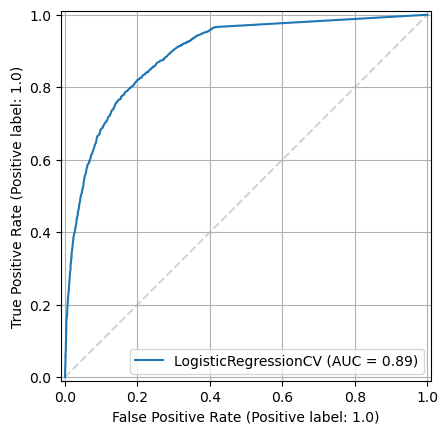

In [10]:
# Create predictions. This function will try to use the columns in the `jaccard` dataframe to predict the link
prob_jac = create_predictions(df_edgelist2, df_test, columns=["jaccard_score"])

# # save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["jaccard"] = prob_jac

### You can try some methods from here as well
https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html

For example maybe nodes link proportionally to their degree

In [11]:
# Calculate pref attachment --> Returns the name of the two nodes, and the product of the degree
pa = nx.preferential_attachment(G, all_edges_nx)
df_pa = pd.DataFrame(list(pa))
df_pa.columns = [0, 1, "pa_score"]

df_edgelist2 = pd.merge(df_edgelist, df_pa, how="left", on=[0,1], validate="1:1")

Intercept: -0.56
pa_score:  1.14
              precision    recall  f1-score   support

           0       0.69      0.91      0.79      6070
           1       0.87      0.60      0.71      6082

    accuracy                           0.75     12152
   macro avg       0.78      0.75      0.75     12152
weighted avg       0.78      0.75      0.75     12152



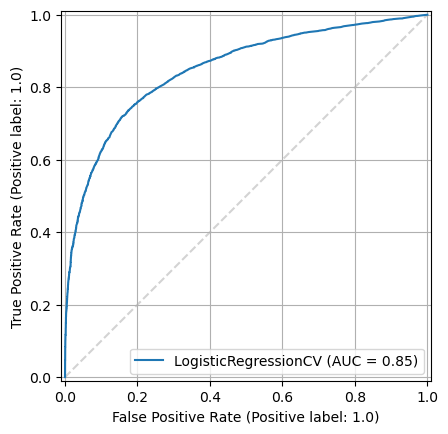

In [12]:
# create predictions as before
prob_jac = create_predictions(df_edgelist2, df_test, columns=["pa_score"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["pa"] = prob_jac

## 3. Methods based on paths
There are also methods that look not only at immediate neighbors, but also at longer-paths. You can do this using matrix multiplication (remember that A^2 represents the number of paths between i and j in two steps)


In [13]:
A = nx.to_numpy_array(G)

#Make higher order powers
A2 = (A @ A)
np.fill_diagonal(A2, 0)
A3 = (A2 @ A)
np.fill_diagonal(A3, 0)
A4 = (A3 @ A)
np.fill_diagonal(A4, 0)


# Put it into the same format as edgelist
df_edgelist2 = df_edgelist.copy()
df_edgelist2["a2"] = A2.reshape(-1)
df_edgelist2["a3"] = A3.reshape(-1)
df_edgelist2["a4"] = A4.reshape(-1)


Intercept: -1.49
a2:  1.10
a3:  17.20
a4: -17.33
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      6070
           1       0.94      0.65      0.76      6082

    accuracy                           0.80     12152
   macro avg       0.83      0.80      0.80     12152
weighted avg       0.83      0.80      0.80     12152



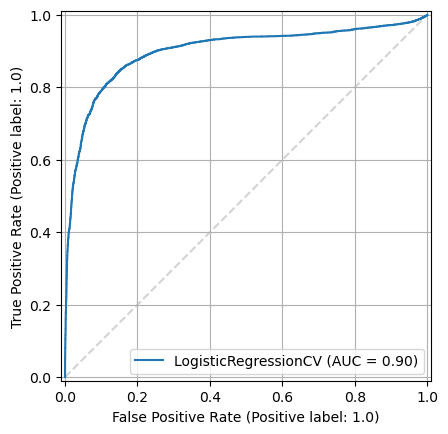

In [14]:
# create predictions
prob_paths = create_predictions(df_edgelist2, df_test, columns=["a2", "a3", "a4"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["paths"] = prob_paths

A more sophisticated method is Katz similarity. The Katz Similarity between two nodes i and j is the sum of the number of walks of __all lengths__ between i and j, but the walks are weighted exponentially decreasing weights based on their lengths. The intuition is that a higher number of short walks between two nodes indicate a stronger connection.


In [15]:
def katz_similarity(g, beta=None, safety=0.95):
    A = gt.adjacency(g).todense()
    if beta is None:
        lam_max = max(abs(np.linalg.eigvals(A)))
        beta = safety / lam_max              # safety < 1 for convergence
    I  = np.eye(A.shape[0])
    S  = np.linalg.inv(I - beta*A) - I
    print(f"Beta: {beta}")
    return S, beta


ks = katz_similarity(g)

# Put it into a nice format
df_edgelist2 = df_edgelist.copy()
df_edgelist2["katz"] = np.array(ks[0]).reshape(-1)

Beta: 0.011148915623848349


Intercept: -1.61
katz:  2.23
              precision    recall  f1-score   support

           0       0.67      0.94      0.78      6070
           1       0.90      0.55      0.68      6082

    accuracy                           0.74     12152
   macro avg       0.78      0.74      0.73     12152
weighted avg       0.78      0.74      0.73     12152



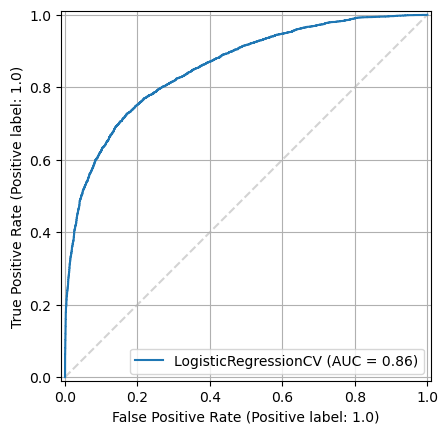

In [16]:
# create predictions (solver="saga" is slower, but converges)
prob_jac = create_predictions(df_edgelist2, df_test, columns=["katz"])#, solver="saga")
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["katz"] = prob_jac

## 4. Methods based on node embeddings (spectral methods and matrix factorization; node2vec)
The following methods will create node embeddings based on:
- spectral method and matrix factorization
- random walks and shallow networks

In order to predict a link, each pair of embeddings needs to be combined (e.g. by computing the L1 norm (np.abs(v1-v2))

* 4.1 shows an example of a spectral method (you can try different methods: TruncatedSVD, PCA, SpectralEmbedding and NMF; you can modify the dimension of the embedding as well)
* 4.2 shows an example of node2vec (you can change the p and q parameters, the length of walks, etc)




In [17]:
def calculate_dist(v1, v2):
    """
    Calculate the L1 distance between two embeddings
    (you could use a different formula, such as (v1*v2))
    """
    #I'm taking the sum, but you could let a downstream model find that out
    return np.sum(np.abs(v1 - v2))

def create_pair_distance(embeddings, G, fun_distance=calculate_dist):
    """
    Calculates the distance between embeddings using calculate_dist
    """
    # Create dictionary with embeddings
    df_clsvd = pd.DataFrame(embeddings)
    df_clsvd.index = G.nodes()
    df_clsvd = {k: row.values for k,row in df_clsvd.iterrows()}


    # Calculate all distances and convert to dictionary
    pairs = list(itertools.combinations(G.nodes(), 2))
    all_pairs = [fun_distance(df_clsvd[n1], df_clsvd[n2]) for n1,n2 in pairs]

    # Concatenate labels with node pairs      
    all_pairs = pd.DataFrame(all_pairs)
    all_pairs =  pd.concat([pd.DataFrame(pairs), all_pairs.reset_index(drop=True)], axis=1)
    all_pairs.columns = [0,1]+[f"_{i}" for i in range(2, len(all_pairs.columns))]

    # Add the reverse of the node pair
    all_pairs = pd.concat([all_pairs, all_pairs.rename(columns={0:1, 1:0})])

    return all_pairs

### 4.1 Example with SVD
Try also PCA, SpectralEmbedding and NMF 

Try different time of embeddings sizes (n_components)

In [18]:
A = nx.to_numpy_array(G)
clusters_svd = TruncatedSVD(n_components=10)
clusters_svd.fit(A)
cl_svd = clusters_svd.components_.T

# clusters_svd = SpectralEmbedding(affinity = 'precomputed', n_components=5)
# clusters_svd.fit(A)
# cl_svd = clusters_svd.embedding_

In [19]:
df_emb = create_pair_distance(cl_svd, G)
df_emb.columns = [0, 1, "svd"]

# Self-loops are removed during th eprediction, so don't worry about those
df_edgelist2 = pd.merge(df_edgelist, df_emb, on=[0,1], how="left", validate="1:1")
df_edgelist2.head()

#You can try to modify calculate_dist

,0,1,edge,svd
0,0,0,0.0,NaN
1,0,1,1.0,0.573193
2,0,217,1.0,0.314104
3,0,476,1.0,0.135625
4,0,1324,1.0,0.040321


Intercept: -0.32
svd:  0.73
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      6070
           1       0.72      0.65      0.68      6082

    accuracy                           0.70     12152
   macro avg       0.70      0.70      0.70     12152
weighted avg       0.70      0.70      0.70     12152



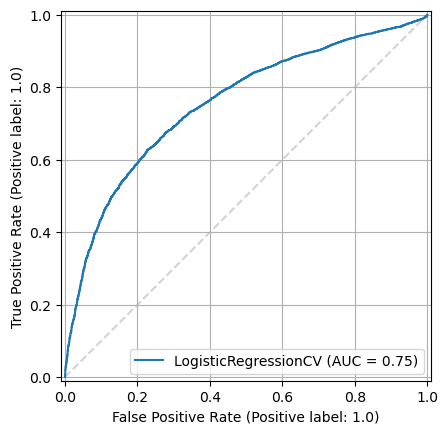

In [20]:
probs = create_predictions(df_edgelist2, df_test, columns=["svd"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["svd"] = probs

## 4.2 Example with node2vec

You can create and save more predictions by changing the q and p parameters

In [21]:
# Generate walks
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, q=0.5, walk_length=30, num_walks=10, workers=8)  

# Embed nodes (dimensions = embedding size)
model = node2vec.fit(window=5, min_count=1, batch_words=4) 
#model = gensim.models.Word2Vec(vector_size = 32, workers=8, window=5, min_count=1, batch_words=4)

# Embeddings as a pandas dataframe
node2vec = pd.DataFrame([model.wv.get_vector(str(_)) for _ in G.nodes()])
node2vec.head()

/Users/garci061/miniforge3/envs/networks/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.413941,0.207666,0.472497,0.706587,0.547693,0.302010,0.132546,-0.134482,-0.089392,0.513770,...,-0.299198,0.462320,0.320765,-0.115648,-0.680780,0.467062,-0.422200,0.431060,-0.554566,0.269928
1,0.449987,-0.050174,0.352047,0.472760,0.059244,0.060627,-0.132564,-0.345985,-0.334736,-0.456419,...,0.132832,0.122090,0.384894,0.349199,-0.122768,0.342414,-0.210582,0.203307,-0.203194,0.183211
2,0.052640,-0.215127,0.381291,0.167857,0.543924,-0.063678,0.223422,-0.383321,0.056943,0.061497,...,0.346919,0.170008,0.121559,-0.750609,-0.342928,0.458787,-0.155851,0.072625,-0.103466,0.341475
3,0.287506,0.227336,0.191286,0.445152,0.092295,0.144735,0.510049,0.197142,-0.688006,-0.128806,...,0.198098,0.463605,0.437293,-1.073664,-0.564220,0.764077,-0.357973,0.064837,-0.083498,-0.283713
4,0.461255,-0.023620,0.112681,0.337616,0.643641,0.172831,-0.144176,-0.061097,0.050219,0.436260,...,-0.003262,0.169093,0.417778,-0.271791,-0.686415,0.259153,-0.650843,0.170913,-0.407188,0.233091


In [22]:
# Create all distances
df_emb = create_pair_distance(node2vec, G)
df_emb.columns = [0, 1, "node2vec"]

# Self-loops are removed during th eprediction, so don't worry about those
df_edgelist2 = pd.merge(df_edgelist, df_emb, on=[0,1], how="left", validate="1:1")
df_edgelist2.head()


,0,1,edge,node2vec
0,0,0,0.0,NaN
1,0,1,1.0,17.700176
2,0,217,1.0,21.253500
3,0,476,1.0,18.948116
4,0,1324,1.0,9.907747


Intercept: -2.82
node2vec: -2.68
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      6070
           1       0.84      0.66      0.74      6082

    accuracy                           0.77     12152
   macro avg       0.78      0.77      0.76     12152
weighted avg       0.78      0.77      0.76     12152



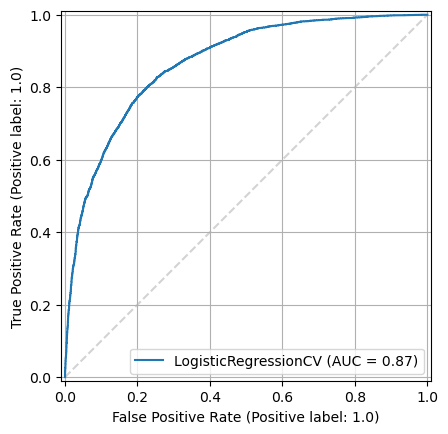

In [23]:
# Caulate predictions
probs = create_predictions(df_edgelist2, df_test, ["node2vec"])
# save the probabilities for later (stacking algorithms)
df_edgelist_no_self_loops["node2vec"] = probs

# 5. Stacking classifiers
For each method we fitted a logisticregression, which returned a probability of two nodes being connected. 

We can now fit a meta-classifier, which takes those predictions and combines them in order to (hopefully) create a better classifier.

You can try different algorithms apart from LogisticRegressionCV: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning


In [24]:
df_edgelist2 = df_edgelist_no_self_loops.loc[:, [0,1]+["jaccard","paths","katz","svd","node2vec","pa"]]
df_edgelist2.head()

,0,1,jaccard,paths,katz,svd,node2vec,pa
1,0,1,0.255108,0.997359,0.599299,0.778305,0.907211,0.501326
2,0,217,0.153586,0.749706,0.479423,0.508538,0.245176,0.339880
3,0,476,0.331871,0.514828,0.454719,0.308443,0.747317,0.297887
4,0,1324,0.990484,0.289992,0.441584,0.221528,0.999941,0.267628
5,0,103,0.999988,0.659281,0.472508,0.217329,0.998923,0.278606


Intercept: -5.80
jaccard: -1.02
pa: -1.40
paths:  0.96
katz:  3.20
svd: -0.70
node2vec:  1.09
              precision    recall  f1-score   support

           0       0.64      0.97      0.77      6070
           1       0.95      0.44      0.60      6082

    accuracy                           0.71     12152
   macro avg       0.79      0.71      0.69     12152
weighted avg       0.79      0.71      0.69     12152



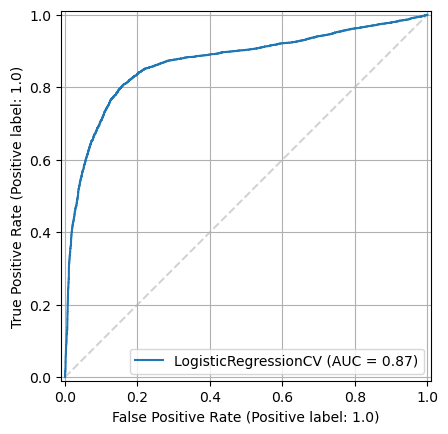

In [25]:
df_test_stack = create_predictions(df_edgelist_no_self_loops, df_test, return_test=True)

# 6. Explore some of the node pairs with the highest probability of a link
You can look at our results and explore which proteins may be interacting 

e.g. using the test dataset (you can also find the ones with the highest probability of being a link in the full dataset)

In [26]:
# Create a dictionary to go from the node index to the text label
d_conv_inv = nx.get_node_attributes(G, "label")
df_test_stack["source"] = df_test_stack[0].map(d_conv_inv)
df_test_stack["target"] = df_test_stack[1].map(d_conv_inv)


# Edges that are not known but are predicted as links
display(df_test_stack
    .loc[(df_test_stack["edge"]==0)  & 
         (df_test_stack["label"]!=1) &  
         (df_test_stack["node2vec"]>0.6)]
    .sort_values(by="pred_prob", ascending=False)
    .head(20)
)

,0,1,label,edge,jaccard,pa,paths,katz,svd,node2vec,pred,pred_prob,source,target
10552,740,287,0,0.0,0.996982,0.702114,0.805193,0.990926,0.415669,0.985207,1.0,0.998360,nwlandry,syedarehaq
9303,773,35,0,0.0,0.958933,0.676565,0.867379,0.975766,0.528902,0.935950,1.0,0.998075,ThManfredi,thilogross
8957,733,344,0,0.0,0.779030,0.638404,0.808754,0.947863,0.538559,0.727941,1.0,0.997063,JanNagler1,alainbarrat
9157,172,364,0,0.0,0.985101,0.525727,0.993017,0.780006,0.477996,0.997958,1.0,0.996936,PerrottaDaniela,elisa_omodei
8886,642,878,0,0.0,0.946887,0.580460,0.932917,0.865306,0.510308,0.878259,1.0,0.996880,AnisabelBento,uvmmathstats
8445,235,393,0,0.0,0.611804,0.822238,0.948466,0.989785,0.843023,0.942319,1.0,0.996864,all_are,spcornelius
9599,161,1165,0,0.0,0.368279,0.731921,0.626921,0.964435,0.892284,0.954613,1.0,0.995926,HirokiSayama,PattyKostkova
8755,273,169,0,0.0,0.891331,0.733366,0.842445,0.933465,0.525571,0.975319,1.0,0.995546,Enri_amico,DaniSBassett
10359,258,733,0,0.0,0.695146,0.826640,0.979792,0.993109,0.820810,0.790445,1.0,0.993440,fede7j,JanNagler1
7840,287,632,0,0.0,0.985101,0.506740,0.421938,0.880704,0.351139,0.945485,1.0,0.991424,syedarehaq,andreasantor0


In [27]:
#d_conv_inv[776], d_conv_inv[560]

https://yeastgenome.org/locus/YMR298W Ceramide synthase subunit; single-span ER membrane protein associated with Lag1p and Lac1p and __required for ceramide synthase activity__, null mutant grows extremely slowly and is defective in ceramide synthesis 1 

https://yeastgenome.org/locus/YCR021C (Heat Shock Protein)  Negative regulator of the H(+)-ATPase Pma1p; stress-responsive protein; hydrophobic plasma membrane localized; induced by heat shock, ethanol treatment, weak organic acid, glucose limitation, and entry into stationary phase 1 2 3 4 5 6 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3974757/
We find that __during heat stress distinct metabolic mechanisms control the abundance of different groups of ceramide species__. Additionally, distinct groups of ceramide species regulated different sets of functionally related genes, indicating that specific sub-groups of lipids participated in different regulatory pathways. These results indicate a previously unrecognized complexity and versatility of lipid-mediated cell regulation.

# 7. Example of Graph Neural Networks (graphSAGE )

The power of GNNs comes from their ability to use the structure of the graph, and the relationships between nodes, to improve their predictions or understanding of the data. They work by updating each node's features based on the features of its neighbors, allowing information to flow across the graph. This is particularly useful when we want to understand the context of a node, as defined by its location within a larger network.


Training started…

Epoch 05 | Loss 0.6799 | Test AUC 0.8087
Epoch 10 | Loss 0.5577 | Test AUC 0.8297
Epoch 15 | Loss 0.5107 | Test AUC 0.8478
Epoch 20 | Loss 0.4773 | Test AUC 0.8496
Epoch 25 | Loss 0.4685 | Test AUC 0.8473
Epoch 30 | Loss 0.4645 | Test AUC 0.8517
Epoch 35 | Loss 0.4580 | Test AUC 0.8548
Epoch 40 | Loss 0.4545 | Test AUC 0.8572
Epoch 45 | Loss 0.4484 | Test AUC 0.8596
Epoch 50 | Loss 0.4415 | Test AUC 0.8637

Training complete



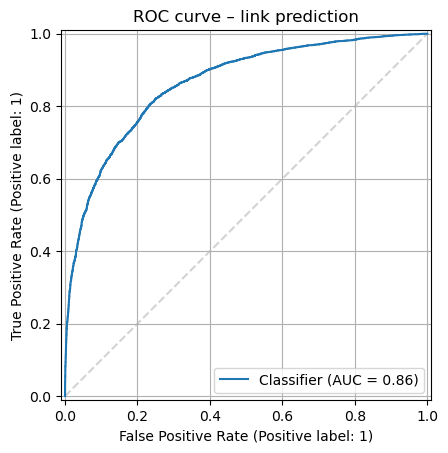

              precision    recall  f1-score   support

         0.0       0.75      0.82      0.79      6082
         1.0       0.80      0.73      0.77      6082

    accuracy                           0.78     12164
   macro avg       0.78      0.78      0.78     12164
weighted avg       0.78      0.78      0.78     12164



In [ ]:
# ---------------------------------------------------------------
# 1.  Build a PyG graph (`Data` object)
# ---------------------------------------------------------------
np.random.seed(1546)
torch.manual_seed(1546)


if network == "ppi":
    df_edges = pd.read_csv(
        "https://github.com/jgarciab/NetworkScience/raw/main/Data/CCSB-Y2H.txt",
        skiprows=1, sep="\t", header=None
    )
else:
    df_edges = pd.read_csv(
        "https://raw.githubusercontent.com/jgarciab/NetworkScience/main/Data/ic2s2_netsci_3.tsv",
        sep="\t", usecols=["source", "target"]
    )
    df_edges.columns = [0, 1]


# Make the graph undirected (add “B→A” for every “A→B”)
df_edges = pd.concat([df_edges, df_edges.rename(columns={0: 1, 1: 0})])

# Build a NetworkX graph and drop self-loops (A→A)
G_nx = nx.from_pandas_edgelist(df_edges, source=0, target=1)
G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

# Keep **only** the largest connected group of nodes
G_nx = G_nx.subgraph(max(nx.connected_components(G_nx), key=len)).copy()

# Relabel node names (which could be strings) to 0,1,2,…
node_map = {old: new for new, old in enumerate(sorted(G_nx.nodes()))}
edges_df = (pd.DataFrame(G_nx.edges())
              .rename(columns={0: "src", 1: "dst"}))
edges_df["src"] = edges_df["src"].map(node_map)
edges_df["dst"] = edges_df["dst"].map(node_map)

# Duplicate again so (src,dst) and (dst,src) are explicitly stored
edges_df = pd.concat(
    [edges_df, edges_df.rename(columns={"src": "dst", "dst": "src"})]
).drop_duplicates()

num_nodes = len(node_map)                     # total unique users/proteins
edge_index = torch.tensor(edges_df.values.T,  # shape [2, num_edges]
                          dtype=torch.long)

# **Node features** – here we use a one-hot identity matrix.
# In real life you would load profile text, protein domains, etc.
x = torch.eye(num_nodes)

# Wrap everything into a PyG “Data” object
data = Data(x=x, edge_index=edge_index)


# ------------------------------------------------------------
# 2. CREATE TRAIN / TEST / NEGATIVE EDGE SPLITS
# ------------------------------------------------------------
# Split **positive** edges (real ones) 90 % / 10 %
u = edges_df["src"].values
v = edges_df["dst"].values
perm = np.random.permutation(len(u))
test_size = int(0.10 * len(u))

train_pos_u, test_pos_u = u[perm[test_size:]], u[perm[:test_size]]
train_pos_v, test_pos_v = v[perm[test_size:]], v[perm[:test_size]]

train_pos_edge = torch.tensor(
    np.stack([train_pos_u, train_pos_v]), dtype=torch.long
)

# Generate the *same* number of **negative** edges (non-existing pairs)
neg_edge_all = negative_sampling(
    edge_index=train_pos_edge,
    num_nodes=num_nodes,
    num_neg_samples=len(u),   # equal to number of positives
    method="sparse",
)
neg_u, neg_v = neg_edge_all.cpu().numpy()

train_neg_u, test_neg_u = neg_u[test_size:], neg_u[:test_size]
train_neg_v, test_neg_v = neg_v[test_size:], neg_v[:test_size]

train_neg_edge = torch.tensor(
    np.stack([train_neg_u, train_neg_v]), dtype=torch.long
)
test_pos_edge = torch.tensor(
    np.stack([test_pos_u, test_pos_v]), dtype=torch.long
)
test_neg_edge = torch.tensor(
    np.stack([test_neg_u, test_neg_v]), dtype=torch.long
)


# ------------------------------------------------------------
# 3. DEFINE THE GRAPH NEURAL-NETWORK COMPONENTS
# ------------------------------------------------------------
class GraphSAGE(nn.Module):
    """
    Simple 2-layer GraphSAGE encoder
    --------------------------------
    Turns every node into a *d*-dimensional vector embedding by
    repeatedly averaging (’mean’) over its neighbours.

    Parameters
    ----------
    in_dim : int
        Size of the input feature for each node (here: num_nodes
        because we used an identity matrix).
    hidden_dim : int
        Size of the hidden & output embedding we want to learn.
    """
    def __init__(self, in_dim: int, hidden_dim: int, drop_p: float = 0.3):
        super().__init__()
        self.conv1 = SAGEConv(
            in_channels=in_dim,
            out_channels=hidden_dim,
            aggr="mean",      # neighbour aggregator
        )
        self.conv2 = SAGEConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            aggr="mean",
        )
        self.dropout = nn.Dropout(p=drop_p)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Run the two message-passing layers.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape ``[num_nodes, in_dim]``.
        edge_index : torch.Tensor
            Edge list of shape ``[2, num_edges]``.

        Returns
        -------
        torch.Tensor
            Final node embeddings of shape ``[num_nodes, hidden_dim]``.
        """
        h = F.relu(self.conv1(x, edge_index))
        h = self.conv2(h, edge_index)
        h = self.dropout(h)
        return h


class MLPPredictor(nn.Module):
    """
    Edge-score predictor
    --------------------
    Tiny 2-layer perceptron that takes two node embeddings
    (source & destination), concatenates them and outputs a
    single logit score ∈ ℝ.  Higher ⇒ more likely the link is real.
    """
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.lin1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor,
                edge_index: torch.Tensor) -> torch.Tensor:
        """
        Compute a score for each edge in *edge_index*.

        Parameters
        ----------
        h : torch.Tensor
            Node embeddings ``[num_nodes, hidden_dim]``.
        edge_index : torch.Tensor
            Edges to score ``[2, num_edges]``.

        Returns
        -------
        torch.Tensor
            Flat tensor of length ``num_edges`` with raw scores
            (logits – we will feed them to `BCEWithLogitsLoss`).
        """
        h_src = h[edge_index[0]]      # embeddings for edge sources
        h_dst = h[edge_index[1]]      # embeddings for edge targets
        h_pair = torch.cat([h_src, h_dst], dim=-1)
        out = self.lin2(F.relu(self.lin1(h_pair)))
        return out.view(-1)           # shape → (num_edges,)


def binary_loss(pos_score: torch.Tensor,
                neg_score: torch.Tensor) -> torch.Tensor:
    """
    Standard binary-cross-entropy loss for link prediction.
    """
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones_like(pos_score),
                        torch.zeros_like(neg_score)])
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score: torch.Tensor,
                neg_score: torch.Tensor) -> float:
    """
    Area-Under-ROC for easy monitoring during training.
    """
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat([torch.ones_like(pos_score),
                        torch.zeros_like(neg_score)]).cpu().numpy()
    return roc_auc_score(labels, scores)



In [ ]:

# ------------------------------------------------------------
# 4. TRAIN THE MODEL
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data and edges to CPU / GPU
data = data.to(device)
train_pos_edge, train_neg_edge = train_pos_edge.to(device), train_neg_edge.to(device)
test_pos_edge,  test_neg_edge  = test_pos_edge .to(device), test_neg_edge .to(device)

# Initialise the networks
model = GraphSAGE(data.num_node_features, hidden_dim=32).to(device)
predictor = MLPPredictor(hidden_dim=32).to(device)

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), predictor.parameters()),
    lr=0.01,
)

print("\nTraining started…\n")
for epoch in range(1, 51):      # 25 epochs
    model.train()
    optimizer.zero_grad()

    # 1) Embed nodes *using only training edges*
    h = model(data.x, train_pos_edge)

    # 2) Score positive & negative edges
    pos_score = predictor(h, train_pos_edge)
    neg_score = predictor(h, train_neg_edge)

    # 3) Back-propagation step
    loss = binary_loss(pos_score, neg_score)
    loss.backward()
    optimizer.step()

    # Every 5 epochs ➜ check AUC on the 10 % held-out edges
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            h = model(data.x, train_pos_edge)     # fresh forward pass
            test_pos_score = predictor(h, test_pos_edge)
            test_neg_score = predictor(h, test_neg_edge)
            print(f"Epoch {epoch:02d} | "
                  f"Loss {loss.item():.4f} | "
                  f"Test AUC {compute_auc(test_pos_score, test_neg_score):.4f}")

print("\nTraining complete\n")


# ------------------------------------------------------------
# 5. BUILD A FRIENDLY TEST TABLE + ROC CURVE
# ------------------------------------------------------------
# Build a DataFrame for easier human inspection
df_test = pd.DataFrame({
    "source": np.concatenate([test_pos_u, test_neg_u]),
    "target": np.concatenate([test_pos_v, test_neg_v]),
    "label" : np.concatenate([np.ones(len(test_pos_u)),
                              np.zeros(len(test_neg_u))]),
})

# Compute final scores
with torch.no_grad():
    h = model(data.x, train_pos_edge)
    df_test["pred"] = np.concatenate([
        predictor(h, test_pos_edge).cpu().numpy(),
        predictor(h, test_neg_edge).cpu().numpy(),
    ])

# Map the numeric node IDs back to the original names/usernames
inverse_map = {v: k for k, v in node_map.items()}
df_test["source"] = df_test["source"].map(inverse_map)
df_test["target"] = df_test["target"].map(inverse_map)

# Plot ROC curve
RocCurveDisplay.from_predictions(df_test["label"], df_test["pred"])
plt.plot([0, 1], [0, 1], "--", color="lightgray", zorder=0)  # diagonal reference
plt.title("ROC curve – link prediction")
plt.grid(True)
plt.show()

# Print threshold-0.5 classification report
print(classification_report(
    df_test["label"], (df_test["pred"] > 0).astype(int)
))


Let's create the data (this is exactly the same code used above, with the same random seed). Don't worry about this code. It's a bit too convoluted.

In [29]:

# Print top 20 predictions
print(df_test.loc[df_test["label"]==0].sort_values(by="pred", ascending=False).head(20))

                source           target  label      pred
10307    aliceschwarze      mrfrank5790    0.0  3.889376
11191       svscarpino         cesifoti    0.0  3.707751
11380          lajello          all_are    0.0  3.685300
8224           Shugars      masonporter    0.0  3.580873
8911        dgarcia_eu      mrfrank5790    0.0  3.533483
6544      tiagopeixoto     DzGuilbeault    0.0  3.391199
7382    danielequercia           _jgyou    0.0  3.344389
9326           luyibov    aliceschwarze    0.0  3.344338
8144    iacopoiacopini           ecozzo    0.0  3.283278
9295       dinacmistry   danielequercia    0.0  3.279587
9963          nwlandry      TahaYasseri    0.0  3.226101
8375      MariaPereda_      ryanjgallag    0.0  3.180893
6818        marco_java       davidlazer    0.0  3.161789
11273        leoferres         NICOatNU    0.0  3.144731
9139   emilio__ferrara           ecozzo    0.0  3.119100
11461      hyejin_youn         cesifoti    0.0  3.086913
8054            pholme       Fe

## This is how we created the network

In [30]:


def create_network_train_test(df, net_name="twitter"):
    df = pd.concat([df, df.rename(columns={0:1, 1:0})])

    G = nx.from_pandas_edgelist(df, source=0, target=1)
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])

    df = pd.DataFrame(G0.edges())
    df = pd.concat([df, df.rename(columns={0:1, 1:0})]).drop_duplicates()

    nodes = df[0].unique()
    d_conv = dict(zip(nodes, range(len(nodes))))
    df[0] = df[0].map(d_conv)
    df[1] = df[1].map(d_conv)

    G = nx.from_pandas_edgelist(df, source=0, target=1)

    adj = nx.to_scipy_sparse_array(G, nodelist=range(len(G)))

    u,v = np.nonzero(adj)
    eids = np.arange(len(u))
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    train_size = len(u) - test_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges and split them for training and testing
    adj_neg =  adj.todense() + np.eye(len(G)) - 1
    neg_u, neg_v = np.nonzero(adj_neg)

    neg_eids = np.random.choice(len(neg_u), len(u))
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    # Positive and negative examples to test (50-50)
    pos = pd.DataFrame(np.array([test_pos_u,test_pos_v]).T)
    pos["label"] = 1
    neg = pd.DataFrame(np.array([test_neg_u,test_neg_v]).T)
    neg["label"] = 0
    df_test = pd.concat([pos,neg])
    len(df_test)

    df_test.to_csv(f"{path_data}{net_name}_network_prediction_test.csv", sep="\t")

    # Network with 10% removed
    G.remove_edges_from(zip(test_pos_u, test_pos_v))
    nx.set_node_attributes(G, {v:k for k,v in d_conv.items()}, name="label")
    nx.write_graphml(G, f"{path_data}{net_name}_network_prediction.graphml")

if 0: #don't run it
    np.random.seed(1546)
    # Create network for challenge (Twitter)
    df = pd.read_csv(f"{path_data}/ic2s2_netsci_3.tsv", sep="\t", usecols=["source", "target"])
    df.columns = [0,1]
    create_network_train_test(df, net_name="twitter")

    np.random.seed(1546)
    # Create network for challenge (PPI)
    df = pd.read_csv("http://interactome.dfci.harvard.edu/S_cerevisiae/download/CCSB-Y2H.txt",sep="\t",header=None)
    create_network_train_test(df, net_name="ppi")